![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Locomotion in The Playground! <a href="https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/locomotion.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a>

In this notebook, we'll walk through a few locomotion environments available in MuJoCo Playground.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".


In [1]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Thu Mar  6 17:28:29 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:0B:00.0  On |                  N/A |
|  0%   40C    P0              23W / 170W |    399MiB / 12288MiB |     82%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
# print("Installing mediapy:")
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [3]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [4]:
# #@title Install MuJoCo Playground
# !pip install playground

In [5]:
#@title Import The Playground

from mujoco_playground import wrapper
from mujoco_playground import registry

# Locomotion

MuJoCo Playground contains a host of quadrupedal and bipedal environments (all listed below after running the command).

In [6]:
registry.locomotion.ALL_ENVS

('BarkourJoystick',
 'BerkeleyHumanoidJoystickFlatTerrain',
 'BerkeleyHumanoidJoystickRoughTerrain',
 'G1JoystickFlatTerrain',
 'G1JoystickRoughTerrain',
 'Go1JoystickFlatTerrain',
 'Go1JoystickRoughTerrain',
 'Go1Getup',
 'Go1Handstand',
 'Go1Footstand',
 'Go2JoystickFlatTerrain',
 'H1InplaceGaitTracking',
 'H1JoystickGaitTracking',
 'Op3Joystick',
 'SpotFlatTerrainJoystick',
 'SpotGetup',
 'SpotJoystickGaitTracking',
 'T1JoystickFlatTerrain',
 'T1JoystickRoughTerrain')

# Quadrupedal

Let's jump right into quadrupedal locomotion! While we have environments available for the Google Barkour and Boston Dynamics Spot robots, the Unitree Go1 environment contains the most trainable policies that were transferred onto the real robot. We'll go right ahead and show a few policies using the Unitree Go1!

First, let's train a joystick policy, which tracks linear and yaw velocity commands.

In [7]:
env_name = 'Go2JoystickFlatTerrain'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)

In [8]:
env_cfg

Kd: 0.5
Kp: 50.0
action_repeat: 1
action_scale: 0.5
command_config:
  a:
  - 1.5
  - 0.8
  - 1.2
  b:
  - 0.9
  - 0.25
  - 0.5
ctrl_dt: 0.02
episode_length: 1000
history_len: 1
noise_config:
  level: 1.0
  scales:
    gravity: 0.05
    gyro: 0.2
    joint_pos: 0.03
    joint_vel: 1.5
    linvel: 0.1
pert_config:
  enable: false
  kick_durations:
  - 0.05
  - 0.2
  kick_wait_times:
  - 1.0
  - 3.0
  velocity_kick:
  - 0.0
  - 3.0
reward_config:
  max_foot_height: 0.1
  scales:
    action_rate: -0.01
    ang_vel_xy: -0.05
    dof_pos_limits: -1.0
    energy: -0.001
    feet_air_time: 0.1
    feet_clearance: -2.0
    feet_height: -0.2
    feet_slip: -0.1
    lin_vel_z: -0.5
    orientation: -5.0
    pose: 0.5
    stand_still: -1.0
    termination: -1.0
    torques: -0.0002
    tracking_ang_vel: 0.5
    tracking_lin_vel: 1.0
  tracking_sigma: 0.25
sim_dt: 0.004
soft_joint_pos_limit_factor: 0.95

## Joystick

Let's train the joystick policy and visualize rollouts:

In [9]:
from mujoco_playground.config import locomotion_params
ppo_params = locomotion_params.brax_ppo_config("Go1JoystickFlatTerrain")
ppo_params.num_envs = 2048 # Modified due to computational constraints. You may increase this number for better performance.

Domain randomization was used to make the policy robust to sim-to-real transfer. Certain environments in the Playground have domain randomization functions implemented. They're available in the registry and can be passed directly to brax RL algorithms. The [domain randomization](https://github.com/google-deepmind/mujoco_playground/blob/main/mujoco_playground/_src/locomotion/go1/randomize.py) function randomizes over friction, armature, center of mass of the torso, and link masses, amongst other simulation parameters.

In [10]:
registry.get_domain_randomizer(env_name)

<function mujoco_playground._src.locomotion.go2.randomize.domain_randomize(model: mujoco.mjx._src.types.Model, rng: jax.Array)>

### Train

The policy takes 7 minutes to train on an RTX 4090.

In [11]:
ckpt_path = epath.Path("checkpoints").resolve() / env_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"{ckpt_path}")

with open(ckpt_path / "config.json", "w") as fp:
  json.dump(env_cfg.to_json(), fp, indent=4)

/home/kanghyunryu/Go2_demo/checkpoints/Go2JoystickFlatTerrain


In [ ]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

def policy_params_fn(current_step, make_policy, params):
  del make_policy  # Unused.
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f"{current_step}"
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)

def progress(num_steps, metrics):
  clear_output(wait=True)
  print("step", num_steps)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress,
    policy_params_fn=policy_params_fn,
)

In [13]:
# test environment
env_cfg = registry.get_default_config(env_name)
eval_env = registry.load(env_name, config=env_cfg)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [14]:
rng = jax.random.PRNGKey(0)
rollout = []
modify_scene_fns = []

state = jit_reset(rng)

for i in range(env_cfg.episode_length):
  act_rng, rng = jax.random.split(rng)
  ctrl = jp.zeros(env.action_size)
  state = jit_step(state, ctrl)
  rollout.append(state)


render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640,
    height=480,
)
media.show_video(frames, fps=fps, loop=False)

100%|██████████| 500/500 [00:00<00:00, 511.29it/s]


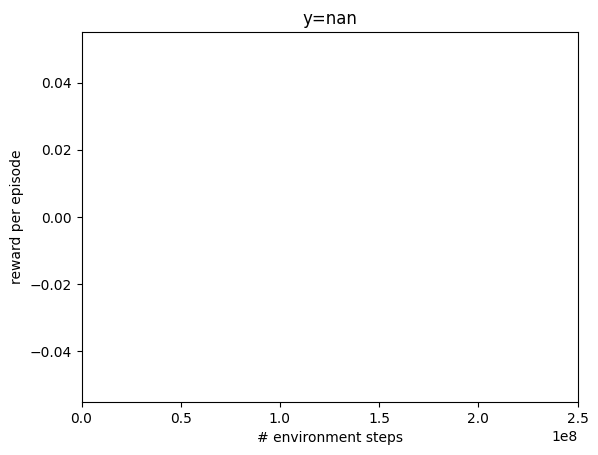

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=registry.load(env_name, config=env_cfg),
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
# Save and reload params.
model_path = './logs/go2_policy'
model.save_params(model_path, params)
params = model.load_params(model_path)

In [ ]:
import pickle
# Save normalizer and policy params to the checkpoint dir.
normalizer_params, policy_params, value_params = params
with open("./logs/go2_policy.pkl", "wb") as f:
  data = {
    "normalizer_params": normalizer_params,
    "policy_params": policy_params,
    "value_params": value_params,
  }
  pickle.dump(data, f)

Let's rollout and render the resulting policy!

In [ ]:
# load the trained policy
make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
    # restore_checkpoint_path="/home/kanghyunryu/mujoco_playground/checkpoints/Go1JoystickFlatTerrain/200540160", # Change this to the path of the checkpoint you want to load
    num_timesteps=0,
)

# If you have problem with checkpoint loading, you can load the params directly
model_path = './logs/go1_policy'
params = model.load_params(model_path)

In [ ]:
# Enable perturbation in the eval env.
env_cfg = registry.get_default_config(env_name)
env_cfg.Kd = 0.7
env_cfg.Kp = 40
env_cfg.pert_config.enable = False
env_cfg.pert_config.velocity_kick = [3.0, 6.0]
env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
env_cfg.command_config.a = [1.5, 0.1, 0.1]
eval_env = registry.load(env_name, config=env_cfg)
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
#@title Rollout and Render
from mujoco_playground._src.gait import draw_joystick_command

x_vel = 1.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.0  #@param {type: "number"}

rng = jax.random.PRNGKey(0)
rollout = []
modify_scene_fns = []

swing_peak = []
rewards = []
linvel = []
angvel = []
track = []
foot_vel = []
rews = []
contact = []
command = jp.array([x_vel, y_vel, yaw_vel])
mujoco_state = []

state = jit_reset(rng)
state.info["command"] = command
for i in range(env_cfg.episode_length):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  state.info["command"] = command
  rews.append(
      {k: v for k, v in state.metrics.items() if k.startswith("reward/")}
  )
  rollout.append(state)
  swing_peak.append(state.info["swing_peak"])
  rewards.append(
      {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
  )
  linvel.append(env.get_global_linvel(state.data))
  angvel.append(env.get_gyro(state.data))
  track.append(
      env._reward_tracking_lin_vel(
          state.info["command"], env.get_local_linvel(state.data)
      )
  )

  feet_vel = state.data.sensordata[env._foot_linvel_sensor_adr]
  vel_xy = feet_vel[..., :2]
  vel_norm = jp.sqrt(jp.linalg.norm(vel_xy, axis=-1))
  foot_vel.append(vel_norm)

  contact.append(state.info["last_contact"])

  xyz = np.array(state.data.xpos[env._torso_body_id])
  xyz += np.array([0, 0, 0.2])
  x_axis = state.data.xmat[env._torso_body_id, 0]
  yaw = -np.arctan2(x_axis[1], x_axis[0])
  modify_scene_fns.append(
      functools.partial(
          draw_joystick_command,
          cmd=state.info["command"],
          xyz=xyz,
          theta=yaw,
          scl=abs(state.info["command"][0])
          / env_cfg.command_config.a[0],
      )
  )


render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640,
    height=480,
    modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

Let's visualize the feet positions and the positional drift compared to the commanded linear and angular velocity. This is useful for debugging how well the policy follows the commands!

In [ ]:
#@title Plot each foot in a 2x2 grid.

swing_peak = jp.array(swing_peak)
names = ["FR", "FL", "RR", "RL"]
colors = ["r", "g", "b", "y"]
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flat):
  ax.plot(swing_peak[:, i], color=colors[i])
  ax.set_ylim([0, env_cfg.reward_config.max_foot_height * 1.25])
  ax.axhline(env_cfg.reward_config.max_foot_height, color="k", linestyle="--")
  ax.set_title(names[i])
  ax.set_xlabel("time")
  ax.set_ylabel("height")
plt.tight_layout()
plt.show()

linvel_x = jp.array(linvel)[:, 0]
linvel_y = jp.array(linvel)[:, 1]
angvel_yaw = jp.array(angvel)[:, 2]

# Plot whether velocity is within the command range.
linvel_x = jp.convolve(linvel_x, jp.ones(10) / 10, mode="same")
linvel_y = jp.convolve(linvel_y, jp.ones(10) / 10, mode="same")
angvel_yaw = jp.convolve(angvel_yaw, jp.ones(10) / 10, mode="same")

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(linvel_x)
axes[1].plot(linvel_y)
axes[2].plot(angvel_yaw)

axes[0].set_ylim(
    -env_cfg.command_config.a[0], env_cfg.command_config.a[0]
)
axes[1].set_ylim(
    -env_cfg.command_config.a[1], env_cfg.command_config.a[1]
)
axes[1].set_ylim(
    -2.0, 2.0
)
axes[2].set_ylim(
    -env_cfg.command_config.a[2], env_cfg.command_config.a[2]
)

for i, ax in enumerate(axes):
  ax.axhline(state.info["command"][i], color="red", linestyle="--")

labels = ["dx", "dy", "dyaw"]
for i, ax in enumerate(axes):
  ax.set_ylabel(labels[i])